In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import cv2
from random import randint
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
# from models import build_model
from skimage.transform import resize
from losers import combine_loss, dice_loss, dice_coeff
from helpers import create_dataset_from_tfrecord, create_dataset_from_directory, create_deserializer
from augs import tf_augs
# from keras.preprocessing.image import load_img
# from keras import Model
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.models import load_model
# from keras.optimizers import Adam
# from keras.utils.vis_utils import plot_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from helpers import create_tfrecords, get_reshaper
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from util import create_coverage_stratas, get_paths

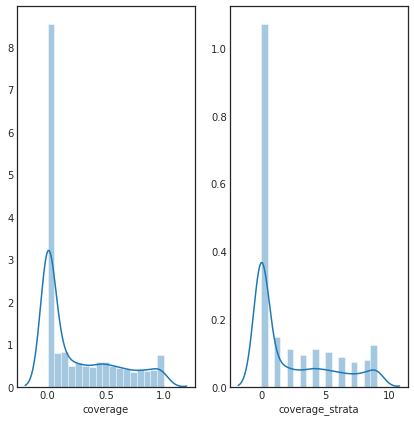

In [3]:
images_salt_stratas = pd.read_csv('/content/drive/My Drive/stratified_data.csv')

f, ax = plt.subplots(1,2, figsize=(7,7))
sns.distplot(images_salt_stratas['coverage'], ax=ax[0])
sns.distplot(images_salt_stratas['coverage_strata'], ax=ax[1])


In [4]:
images_salt_stratas.head()

,id,mask,img,coverage,coverage_strata
0,bf05a52a6b,./drive/My Drive/tgs/train/masks/bf05a52a6b.png,./drive/My Drive/tgs/train/images/bf05a52a6b.png,0.000196,0
1,bfbea83faa,./drive/My Drive/tgs/train/masks/bfbea83faa.png,./drive/My Drive/tgs/train/images/bfbea83faa.png,0.409960,4
2,bfa7ee102e,./drive/My Drive/tgs/train/masks/bfa7ee102e.png,./drive/My Drive/tgs/train/images/bfa7ee102e.png,0.960396,9
3,bfac8e63cb,./drive/My Drive/tgs/train/masks/bfac8e63cb.png,./drive/My Drive/tgs/train/images/bfac8e63cb.png,0.000000,0
4,bf76c8aff3,./drive/My Drive/tgs/train/masks/bf76c8aff3.png,./drive/My Drive/tgs/train/images/bf76c8aff3.png,0.128223,1


In [0]:
train_index, valid_index = train_test_split(images_salt_stratas.index, test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

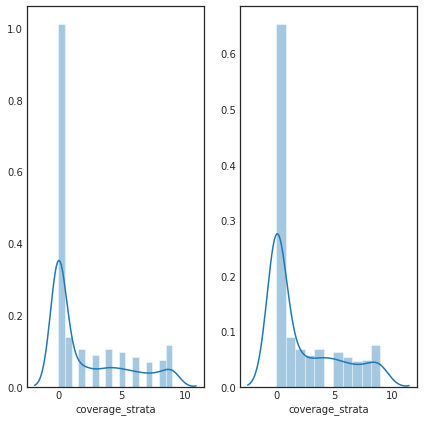

In [6]:
f, ax = plt.subplots(1, 2, figsize=(7,7))
sns.distplot(images_salt_stratas.loc[train_index].coverage_strata, ax=ax[0])
sns.distplot(images_salt_stratas.loc[valid_index].coverage_strata, ax=ax[1])

In [0]:
train_imgs, valid_imgs = train_test_split([(i, m) for i, m in zip(images_salt_stratas['img'].values, images_salt_stratas['mask'].values)], test_size=0.2, stratify=images_salt_stratas.coverage_strata, random_state=1337)

In [0]:
#     create_tfrecords(train_imgs, '/content/drive/My Drive/train_record', [get_reshaper()])
#     create_tfrecords(valid_imgs, '/content/drive/My Drive/test_record', [get_reshaper()])

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    # Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    # uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    output_layer = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)

    return output_layer

In [0]:
def print_history(history):
  fig, ax = plt.subplots(1, 2, figsize=(16, 9))
  ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
  ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
  ax[0].legend()
  ax[1].plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
  ax[1].plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
  ax[1].legend()

In [11]:
input_layer = tf.keras.layers.Input((128, 128, 1))
output_layer = build_model(input_layer, 16)
model = tf.keras.models.Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=["accuracy", dice_coeff])

W0813 12:23:12.421368 139734997768064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 12:23:13.413115 139734997768064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
train_ds = create_dataset_from_directory('/content/drive/My Drive/train_record', create_deserializer(augmentation=tf_augs), batch_size=32)

test_ds = create_dataset_from_directory('/content/drive/My Drive/test_record', create_deserializer(), batch_size=32)



W0813 12:23:18.184414 139734997768064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tfAugmentor/Augmentor.py:20: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard('./comb_model', histogram_freq=1)
# tbc=TensorBoardColab()
epochs = 200
batch_size = 20
# train_ds = train_ds.batch(20)


In [0]:
train_ds = train_ds.shuffle(32)
train_ds = train_ds.repeat(200)

In [0]:
history = model.fit(train_ds, validation_data=test_ds,validation_steps=25,steps_per_epoch=100,
                    epochs=200,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/200
 42/100 [===========>..................] - ETA: 6:11 - loss: 0.6557 - acc: 0.7412 - dice_coeff: 0.3232

In [0]:
print_history(history)

In [0]:
img = cv2.imread('/content/drive/My Drive/tgs/train/images/fff987cdb3.png', cv2.IMREAD_GRAYSCALE)
img = (cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC).astype(np.float64) / 255.0).reshape((1,128,128,1))

In [0]:
a = model.predict(img)

In [0]:
a = (a.reshape((128,128))) * 255.0


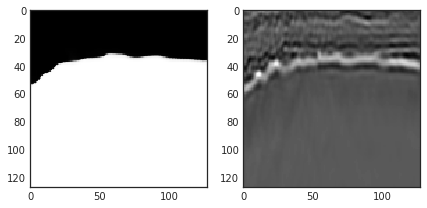

In [46]:
f, ax = plt.subplots(1, 2, figsize=(7,7))
plt.imshow(a, cmap='gray')

ax[0].imshow(a.astype(np.uint8), cmap='gray')
ax[1].imshow((img * 255.0).reshape((128,128)).astype(np.uint8), cmap='gray')

In [20]:
iterator = train_ds.make_one_shot_iterator()
next_element = iterator.get_next()

W0813 11:11:28.122540 139774256736128 deprecation.py:323] From <ipython-input-20-41b483c30021>:1: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [23]:
a = next_element
a

(<tf.Tensor: id=5559, shape=(32, 128, 128, 1), dtype=float64, numpy=
 array([[[[0.61568627],
          [0.61960784],
          [0.61176471],
          ...,
          [0.46666667],
          [0.49803922],
          [0.50196078]],
 
         [[0.6       ],
          [0.61176471],
          [0.61176471],
          ...,
          [0.50588235],
          [0.52941176],
          [0.5254902 ]],
 
         [[0.57254902],
          [0.59607843],
          [0.60392157],
          ...,
          [0.54901961],
          [0.55686275],
          [0.54509804]],
 
         ...,
 
         [[0.53333333],
          [0.58431373],
          [0.63921569],
          ...,
          [0.50588235],
          [0.56470588],
          [0.63529412]],
 
         [[0.5372549 ],
          [0.59215686],
          [0.64705882],
          ...,
          [0.60392157],
          [0.6627451 ],
          [0.71372549]],
 
         [[0.54117647],
          [0.59215686],
          [0.63529412],
          ...,
          [0.67058

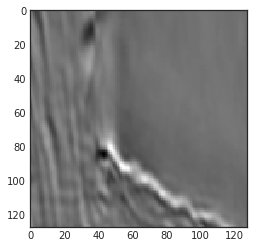

In [30]:
plt.imshow(a[0][7].numpy().reshape((128,128)) * 255.0, cmap='gray', vmin=0, vmax=255)